# Motivation of this file
Our goal is to fine-tune Resnet 18, and other vision models, to see if they can successfully predict Letterboxd average ratings based on movie posters.
1. Load dataset of posters using PosterDataset
2. Pass dataset into a ResNet or CLIP-based trainer.
3. Report results.

In [ ]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


FOLDERNAME = 'cs229_proj/'


assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd drive/My\ Drive/$FOLDERNAME/

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1FYI1gIgILgT31h2y_QMmBZOwkDqTPrg-/cs229_proj


In [ ]:
!ls
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git


 archive_data			     movieid_to_data.json
 baseline_models.ipynb		     movie_industry.csv
 boxd_scrape.ipynb		     movies_embeddings_full.csv
 boxd_scrape_jerry.ipynb	     movies_full.csv
 collect_movie_posters.ipynb	     movie_to_ebert_rating.json
 ebert_html			     movie_to_jesse_rating.json
 embeddings.json		    'related papers'
 html				     resnet_transfer_learning.ipynb
 image_embeddings_playground.ipynb   rotten_tomatoes_movies.csv
 imagenet_classes.txt		     SampleMoviePosters
 jesse_html			     tmdb_5000_credits.csv
 letterboxd_posters		     tmdb_5000_movies.csv
 make_embeddings.ipynb		     user_ratings_full.csv
 more_models.ipynb		     user_to_rating.csv
 MovieGenre.csv			     user_to_rating_dict.json
     |████████████████████████████████| 64 kB 1.9 MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=fbea4aa4539d4e2d51084d3a750652de9416c7ec7be5d8b20c7e2bc8707b62d5
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd8506193

In [ ]:
import numpy as np
from PIL import Image # for viewing images
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import time
import copy

import torch
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from poster_dataset import PosterDataset
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Uses folder and movie_id to create path where image can be found and displayed

def get_poster_path(movie_id, movie_data):
    folder_num = str(movie_data[3]) + "/"
    img_name = movie_id + '.jpg'
    return '/content/drive/My Drive/cs229_proj/letterboxd_posters/' + folder_num + img_name


In [ ]:
movies_full_path = '/content/drive/My Drive/cs229_proj/movies_full.csv'

movies_full_df = pd.read_csv(movies_full_path)
movies_full_df['boxd_vote_average'][0]

8.645801351141731

## Part 2: Dataloaders, Training Paradigm
A model trainer, dataloaders, and defined losses.
https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# choose random movies to add to training and validation dataset
n_train = 1000
n_val = 200
inds = np.random.choice(len(movies_full_df), size=n_train+n_val)
train = inds[:n_train]
val = inds[n_train:]
posters_dataset_train = PosterDataset('letterboxd_posters/', movies_full_df, train, data_transforms['train'])
posters_dataset_val = PosterDataset('letterboxd_posters/', movies_full_df, val, data_transforms['val'])
image_datasets = {'train': posters_dataset_train, 'val': posters_dataset_val}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

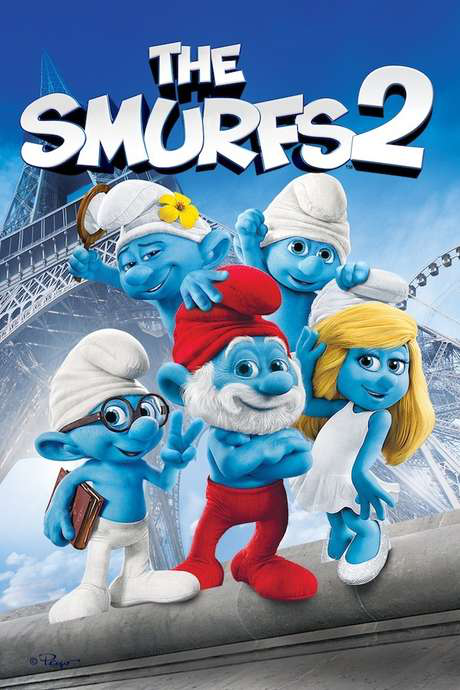

In [ ]:
# sanity checks

# print(movies_full_df.iloc[train[1]])
# print(len(posters_dataset_train))
# posters_dataset_train.get_poster(0)
# print(posters_dataset_train[0])
posters_dataset_train.get_poster(train[0])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float("inf")

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    # print(outputs[0], labels, criterion(outputs[0], labels))
                    loss = criterion(outputs[0], labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# load resnet and rewire the last layer
from torch import nn, optim
from torchvision import transforms
from torchvision.models import resnet50, alexnet, densenet121

# FOR DENSENET:
model_ft = densenet121(pretrained=True)
num_ftrs = model_ft.classifier.in_features

# FOR RESNET-50:
# model_ft = resnet50(pretrained=True)
# num_ftrs = model_ft.fc.in_features

class ScaleByTen(nn.Module):
  def __init__(self):
    super(ScaleByTen, self).__init__()

  def forward(self, tensors):
    return torch.mul(tensors, 10.)

# Modify the last layer so that it outputs a single real value
# https://discuss.pytorch.org/t/resnet-basic-modifications-multi-target-regression/86278

# FOR RESNET-50:
# model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, 1), nn.Sigmoid(), ScaleByTen())
# model_ft.fc = nn.Linear(num_ftrs, 1)

# FOR DENSENET:
model_ft.classifier = nn.Sequential(nn.Linear(num_ftrs, 1), nn.Sigmoid(), ScaleByTen())
model_ft = model_ft.to(device)

# Train based on MSE loss
criterion = nn.MSELoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
# train the thing!!
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


100%|██████████| 1000/1000 [02:32<00:00,  6.57it/s]


train Loss: 1.3831


100%|██████████| 200/200 [00:09<00:00, 20.88it/s]


val Loss: 2.2216

Epoch 1/24
----------


100%|██████████| 1000/1000 [02:31<00:00,  6.58it/s]


train Loss: 1.3737


100%|██████████| 200/200 [00:09<00:00, 20.99it/s]


val Loss: 1.9313

Epoch 2/24
----------


100%|██████████| 1000/1000 [02:31<00:00,  6.60it/s]


train Loss: 1.3527


100%|██████████| 200/200 [00:09<00:00, 21.23it/s]


val Loss: 2.0588

Epoch 3/24
----------


100%|██████████| 1000/1000 [02:31<00:00,  6.62it/s]


train Loss: 1.3627


100%|██████████| 200/200 [00:09<00:00, 20.79it/s]


val Loss: 5.6025

Epoch 4/24
----------


100%|██████████| 1000/1000 [02:34<00:00,  6.49it/s]


train Loss: 1.3642


100%|██████████| 200/200 [00:09<00:00, 20.49it/s]


val Loss: 2.7065

Epoch 5/24
----------


100%|██████████| 1000/1000 [02:35<00:00,  6.45it/s]


train Loss: 1.3481


100%|██████████| 200/200 [00:09<00:00, 20.46it/s]


val Loss: 3.7100

Epoch 6/24
----------


100%|██████████| 1000/1000 [02:35<00:00,  6.43it/s]


train Loss: 1.3631


100%|██████████| 200/200 [00:09<00:00, 20.40it/s]


val Loss: 1.9379

Epoch 7/24
----------


100%|██████████| 1000/1000 [02:36<00:00,  6.41it/s]


train Loss: 1.2774


100%|██████████| 200/200 [00:09<00:00, 20.61it/s]


val Loss: 2.2601

Epoch 8/24
----------


100%|██████████| 1000/1000 [02:37<00:00,  6.34it/s]


train Loss: 1.2747


100%|██████████| 200/200 [00:09<00:00, 20.13it/s]


val Loss: 1.8556

Epoch 9/24
----------


100%|██████████| 1000/1000 [02:36<00:00,  6.40it/s]


train Loss: 1.2768


100%|██████████| 200/200 [00:09<00:00, 20.75it/s]


val Loss: 2.1480

Epoch 10/24
----------


100%|██████████| 1000/1000 [02:35<00:00,  6.44it/s]


train Loss: 1.2561


100%|██████████| 200/200 [00:09<00:00, 20.80it/s]


val Loss: 2.8716

Epoch 11/24
----------


100%|██████████| 1000/1000 [02:35<00:00,  6.41it/s]


train Loss: 1.2551


100%|██████████| 200/200 [00:09<00:00, 20.44it/s]


val Loss: 2.8549

Epoch 12/24
----------


100%|██████████| 1000/1000 [02:34<00:00,  6.47it/s]


train Loss: 1.2471


100%|██████████| 200/200 [00:09<00:00, 21.08it/s]


val Loss: 3.2629

Epoch 13/24
----------


100%|██████████| 1000/1000 [02:33<00:00,  6.50it/s]


train Loss: 1.2288


100%|██████████| 200/200 [00:09<00:00, 20.79it/s]


val Loss: 3.0830

Epoch 14/24
----------


100%|██████████| 1000/1000 [02:33<00:00,  6.53it/s]


train Loss: 1.2411


100%|██████████| 200/200 [00:09<00:00, 20.76it/s]


val Loss: 2.6429

Epoch 15/24
----------


100%|██████████| 1000/1000 [02:33<00:00,  6.51it/s]


train Loss: 1.2483


100%|██████████| 200/200 [00:09<00:00, 21.20it/s]


val Loss: 3.9893

Epoch 16/24
----------


100%|██████████| 1000/1000 [02:31<00:00,  6.59it/s]


train Loss: 1.2186


100%|██████████| 200/200 [00:09<00:00, 21.37it/s]


val Loss: 4.0015

Epoch 17/24
----------


100%|██████████| 1000/1000 [02:30<00:00,  6.66it/s]


train Loss: 1.2263


100%|██████████| 200/200 [00:09<00:00, 22.14it/s]


val Loss: 4.9339

Epoch 18/24
----------


100%|██████████| 1000/1000 [02:28<00:00,  6.71it/s]


train Loss: 1.2410


100%|██████████| 200/200 [00:09<00:00, 21.84it/s]


val Loss: 4.0491

Epoch 19/24
----------


100%|██████████| 1000/1000 [02:29<00:00,  6.68it/s]


train Loss: 1.2278


100%|██████████| 200/200 [00:09<00:00, 21.48it/s]


val Loss: 3.6163

Epoch 20/24
----------


100%|██████████| 1000/1000 [02:33<00:00,  6.50it/s]


train Loss: 1.2170


100%|██████████| 200/200 [00:09<00:00, 21.12it/s]


val Loss: 4.1387

Epoch 21/24
----------


100%|██████████| 1000/1000 [02:30<00:00,  6.66it/s]


train Loss: 1.2227


100%|██████████| 200/200 [00:09<00:00, 21.42it/s]


val Loss: 4.1749

Epoch 22/24
----------


100%|██████████| 1000/1000 [02:32<00:00,  6.56it/s]


train Loss: 1.2174


100%|██████████| 200/200 [00:09<00:00, 20.28it/s]


val Loss: 4.1561

Epoch 23/24
----------


100%|██████████| 1000/1000 [02:33<00:00,  6.53it/s]


train Loss: 1.2072


100%|██████████| 200/200 [00:09<00:00, 21.18it/s]


val Loss: 3.9277

Epoch 24/24
----------


100%|██████████| 1000/1000 [02:33<00:00,  6.49it/s]


train Loss: 1.2298


100%|██████████| 200/200 [00:09<00:00, 20.97it/s]


val Loss: 2.6769

Training complete in 67m 52s
Best val loss: 0.000000


In [ ]:
print(model_ft.forward(posters_dataset_val[2][0].unsqueeze(0).to(device)))
print(posters_dataset_val[2][1])

tensor([[4.5471]], device='cuda:0', grad_fn=<MulBackward0>)
5.717172


Results so far (MSE)

(last layer replaced with scalar value -> sigmoid * 10)
(training set n = 1000 and val set n = 200 are fixed)
* Resnet-50, 25 epochs, LR = 0.0001 on Adam: train 1.39, val 1.61
* DenseNet, 25 epochs, LR = 0.0001 on Adam: train 1.27, val 1.85. 

Remarks:
* As training improved, val accuracy decreased. Suggestive of overfitting?

# EVERYTHING BELOW IS OLD CODE

In [ ]:
# get clip embeddings
import clip
clip_model, clip_transform = clip.load("ViT-B/32", device=device)
clip_transform.transforms = clip_transform.transforms[2:] 
clip_model.encode_image(clip_transform[posters_dataset[2][0]])

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 62.7MiB/s]


In [ ]:
# color transform
resnet_transform = transforms.Compose([            #[1]
 transforms.Resize(256),                    #[2]
 transforms.CenterCrop(224),                #[3]
 transforms.ToTensor(),
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225]                  #[7]
 )])

# use untransform to visualize images
resnet_untransform = transforms.Compose([            #[1]
 transforms.Normalize(                      #[5]
 mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],                #[6]
 std=[1/0.229, 1/0.224, 1/0.225]                  #[7]
 )])

resnet_model = resnet18(pretrained=True)
for param in resnet_model.parameters():
    param.requires_grad = False

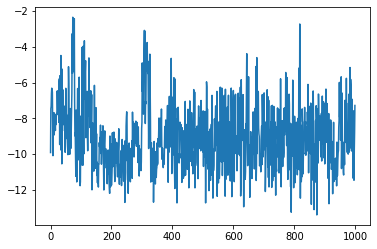

In [ ]:
# the output vector of resnet18 is a classification between 1000 images
resnet_model.eval()
img_ind = 4
transformed = posters_dataset_train[img_ind][0]
input_batch = transformed.unsqueeze(0)
output = resnet_model.forward(input_batch)
probabilities = torch.nn.functional.softmax(output[0], dim=0)
plt.plot(probabilities.log())

In [ ]:
# run this line if you need to map the imagenet vector to class object names
# !wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

In [ ]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())


barn spider 0.09514651447534561
tick 0.08802291750907898
spotlight 0.06526439636945724
fly 0.045674290508031845
ant 0.04369363933801651
